In [325]:
import pandas as pd  

df = pd.read_csv('preprocessed_data.csv')

df.head()

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
0,90049,11645 Montana Ave APT 229,CONDO,1973,4645.390594,79.432065,1,1.0,3.0,"['Tile', 'Wood']",...,2999.0,"[('2022-08-12', 699000)]",3050,4,1,1,1,0,1,1
1,90066,4040 Grand View Blvd UNIT 15,TOWNHOUSE,1961,11561.886452,78.131423,2,1.5,3.0,['Other'],...,3997.0,"[('2015-10-21', 450000), ('2005-04-07', 396000)]",3100,0,1,1,0,0,0,0
2,91303,7305 Milwood Ave APT 3,CONDO,1981,90.301716,90.301716,2,1.0,3.2,[],...,3499.0,"[('2009-11-13', 85000), ('2007-04-18', 299000)...",2800,0,1,1,0,0,0,0
3,91040,8701 Hillrose St,SINGLE_FAMILY,1945,7098.170143,129.320976,2,1.5,1.0,[],...,3781.0,"[('2021-06-29', 3350), ('2019-01-22', 3150)]",3600,2,0,0,0,0,0,0
4,91325,17123 Roscoe Blvd UNIT 2,APARTMENT,1971,30031.677454,127.091304,3,2.0,3.2,[],...,3170.0,"[('2011-11-28', 140000), ('2011-09-16', 151300...",3100,2,1,1,1,0,0,0


In [326]:
df.columns

Index(['zipcode', 'streetAddress', 'homeType', 'yearBuilt', 'lotAreaValue',
       'livingAreaValue', 'bedrooms', 'bathrooms', 'stories', 'flooring',
       'heating', 'cooling', 'fireplaceFeatures', 'taxAssessedValue',
       'zestimate', 'rentZestimate', 'sold-history', 'price',
       'parkingCapacity', 'hasCooling', 'hasHeating', 'hasFireplace',
       'hasPrivatePool', 'hasSpa', 'hasView'],
      dtype='object')

In [327]:
df["homeType"].value_counts()

homeType
SINGLE_FAMILY    3392
CONDO             937
MULTI_FAMILY      430
TOWNHOUSE         304
APARTMENT          22
MANUFACTURED       11
LOT                 7
Name: count, dtype: int64

### Distributions

In [328]:
def calc_num_of_bins_freedman_rule(data):
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    binwidth = 2 * iqr / (len(data) ** (1/3))
    num_bins = int((max(data) - min(data)) / binwidth)
    return num_bins
    
def calc_num_of_bins_scott_rule(data):
    num_bins = int((max(data) - min(data)) / (3.5 * np.std(data) / len(data) ** (1/3)))
    return num_bins

def calc_num_of_bins_sturges_rule(data):
    num_bins = int(np.log2(len(data)) + 1)
    return num_bins

def calc_binwidth(data, num_bins):
    binwidth = (max(data) - min(data)) / num_bins
    return binwidth

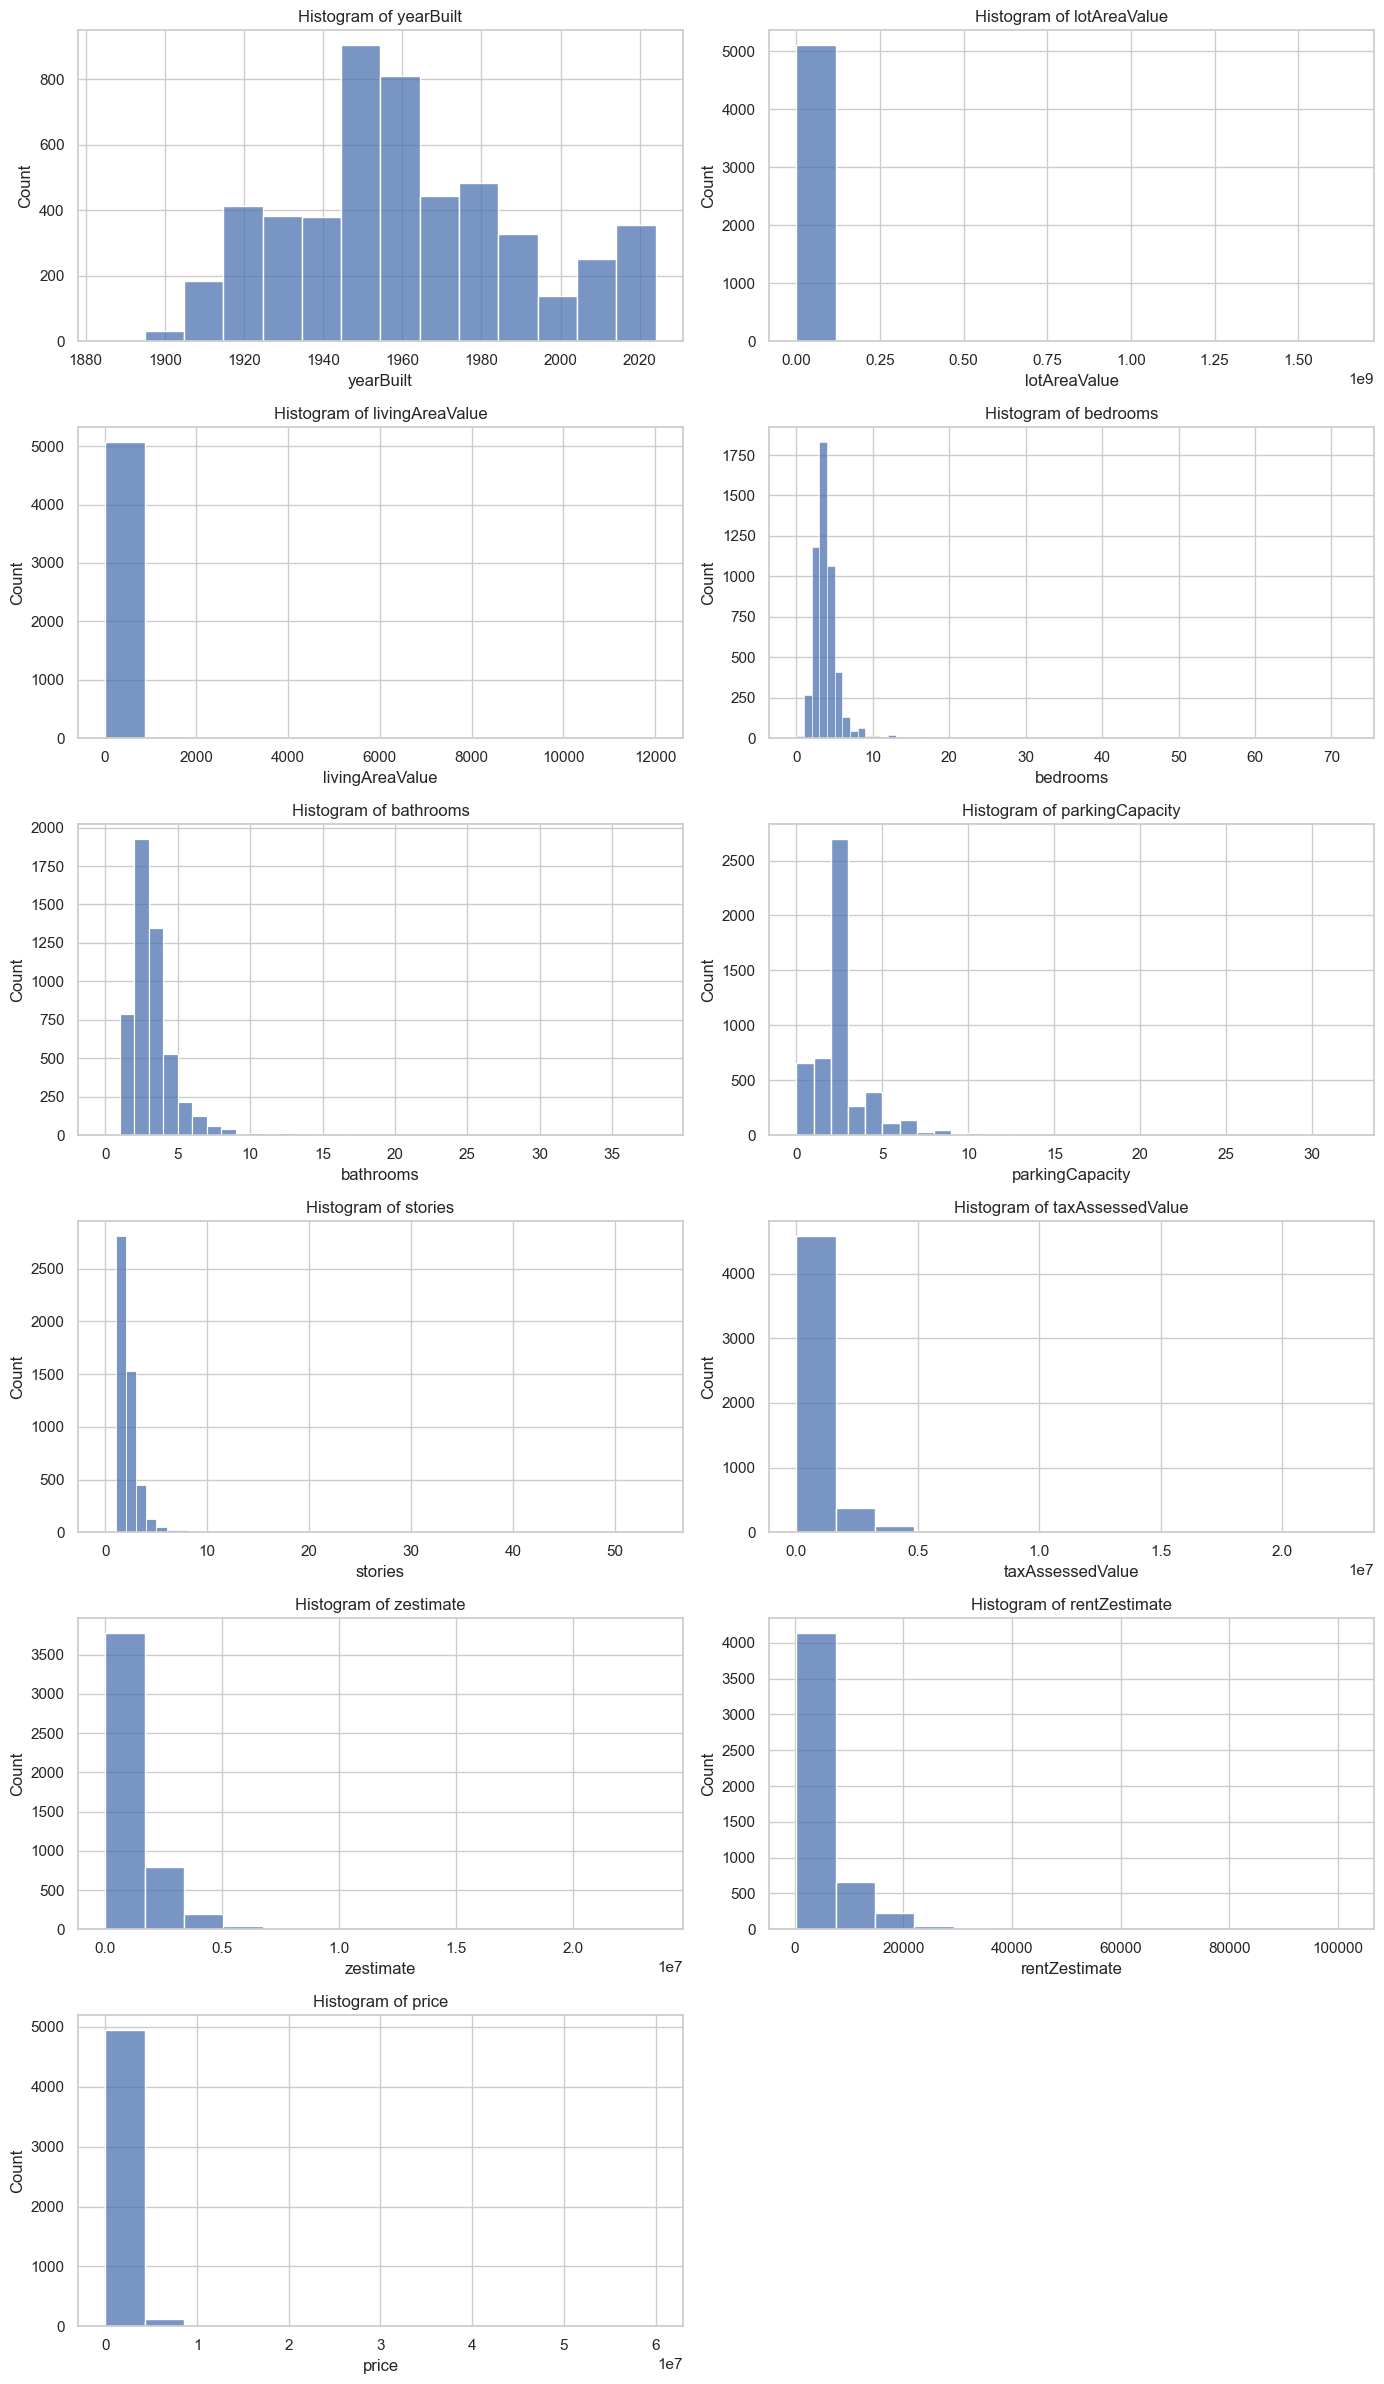

In [329]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math


features = ["yearBuilt", "lotAreaValue", "livingAreaValue", "bedrooms", "bathrooms", "parkingCapacity", "stories",
            "taxAssessedValue", "zestimate", "rentZestimate", "price"]

num_features = len(features)

num_cols = 2
num_rows = int(np.ceil(num_features / num_cols))

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7 * num_cols, 4 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    if feature in ["bedrooms", "bathrooms", "stories", "parkingCapacity"]:
        bins = range(math.ceil(min(df[feature])), math.ceil(max(df[feature])) + 1)
        sns.histplot(df[feature], bins=bins, kde=False, ax=axes[i])
    else:
        sns.histplot(df[feature], bins='sturges', kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

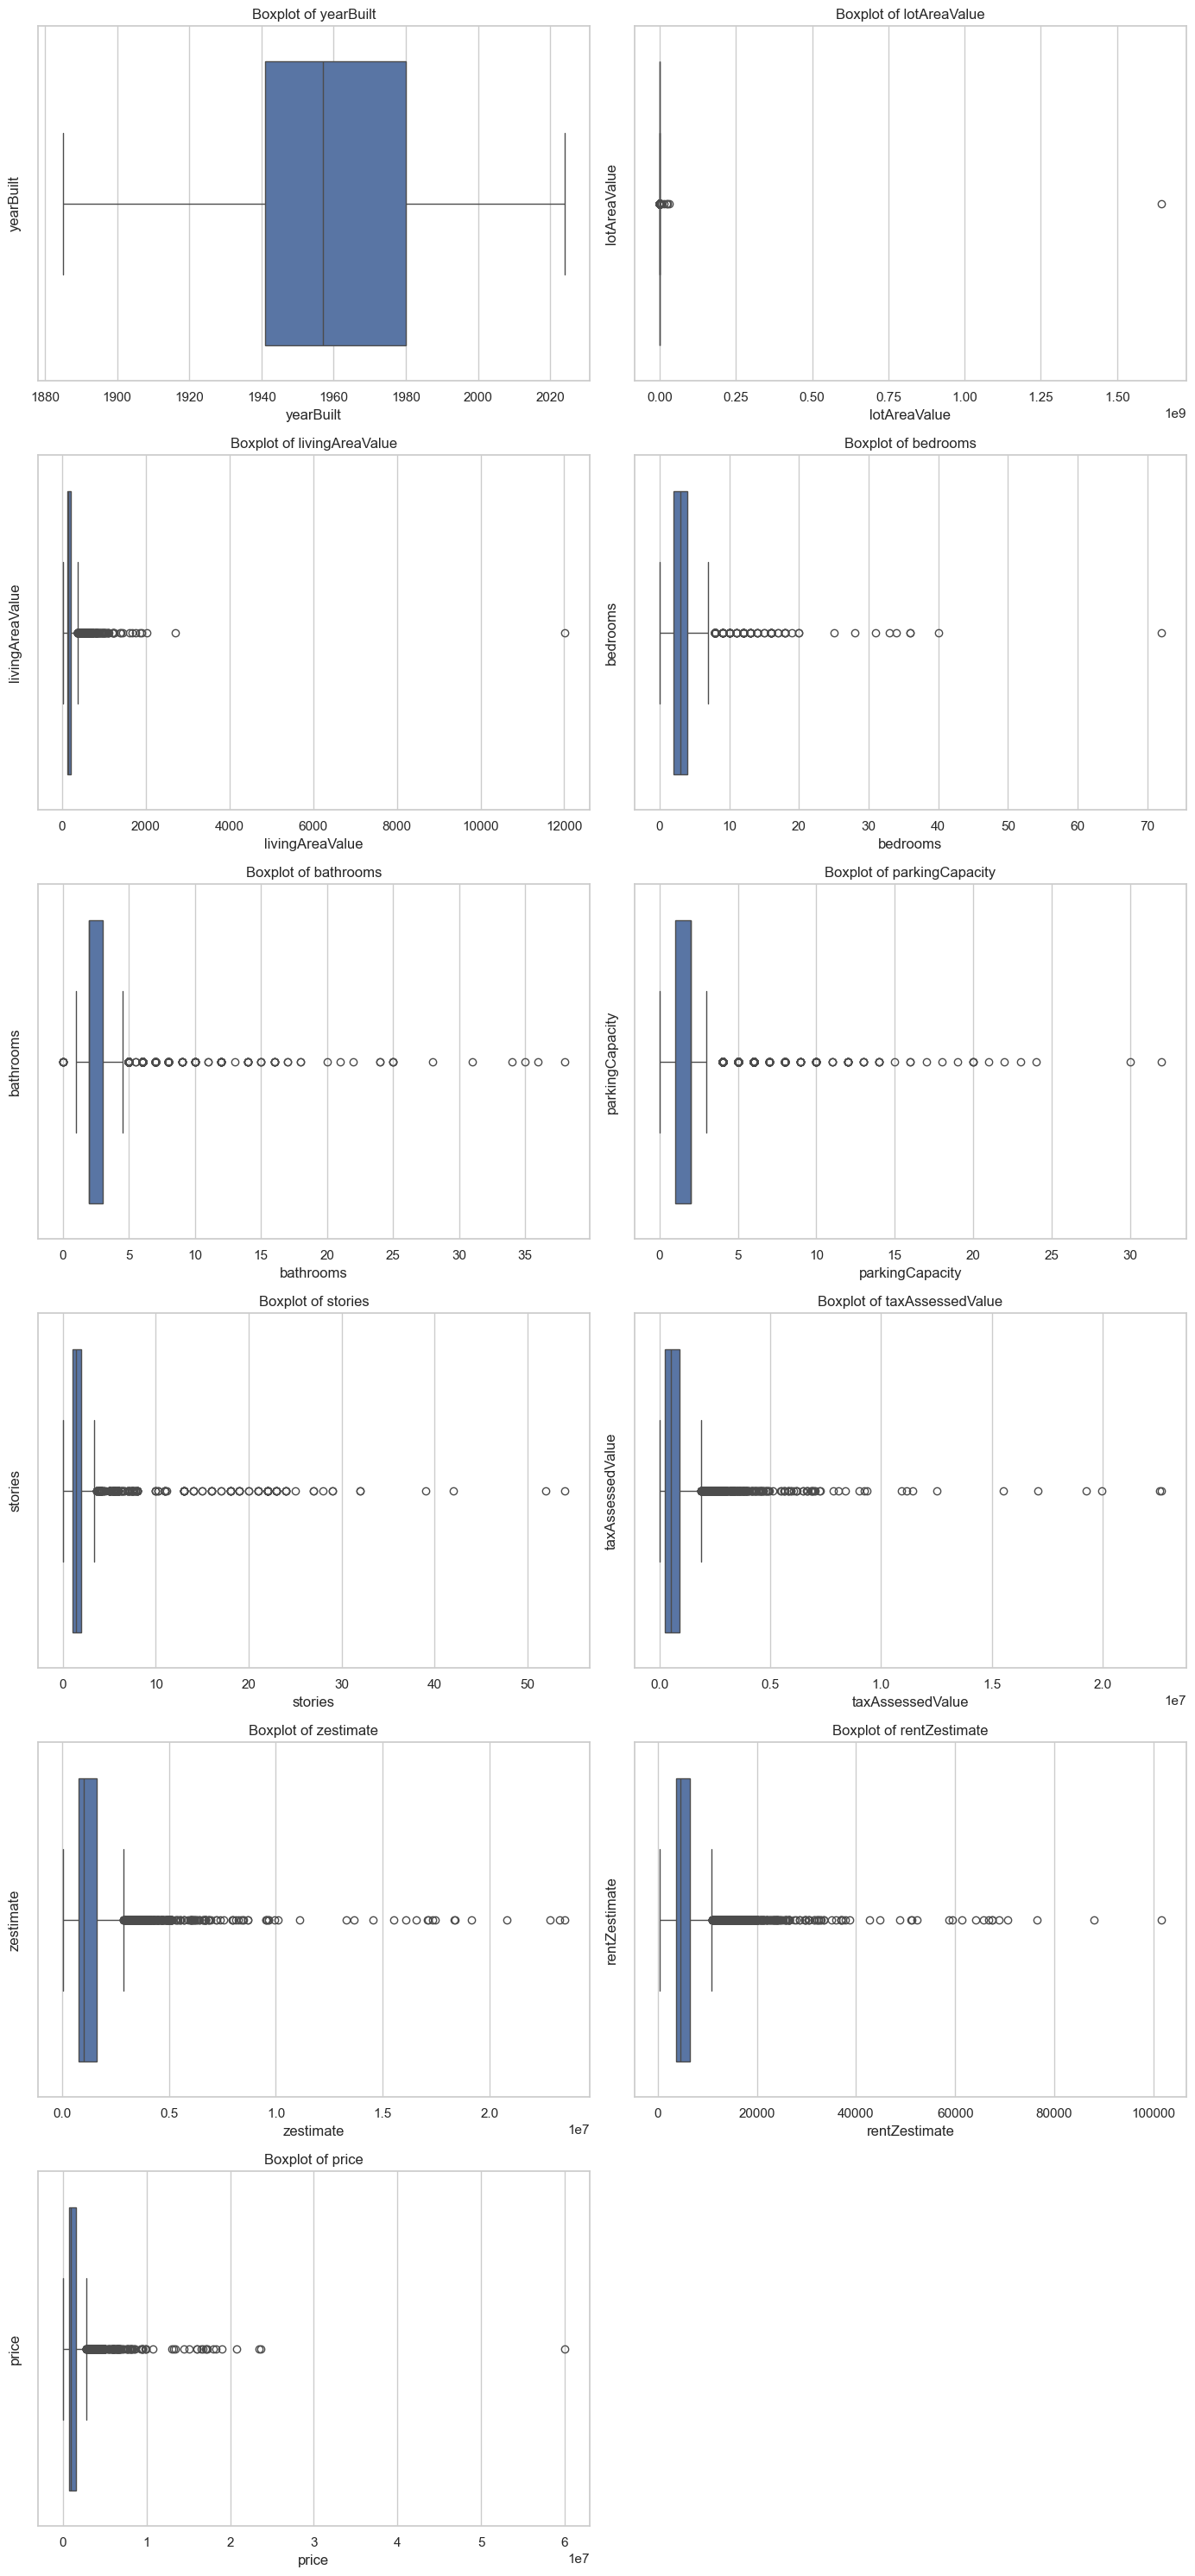

In [330]:
num_cols = 2
num_rows = int(np.ceil(num_features / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7 * num_cols, 5 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_ylabel(feature)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

In [331]:
def show_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

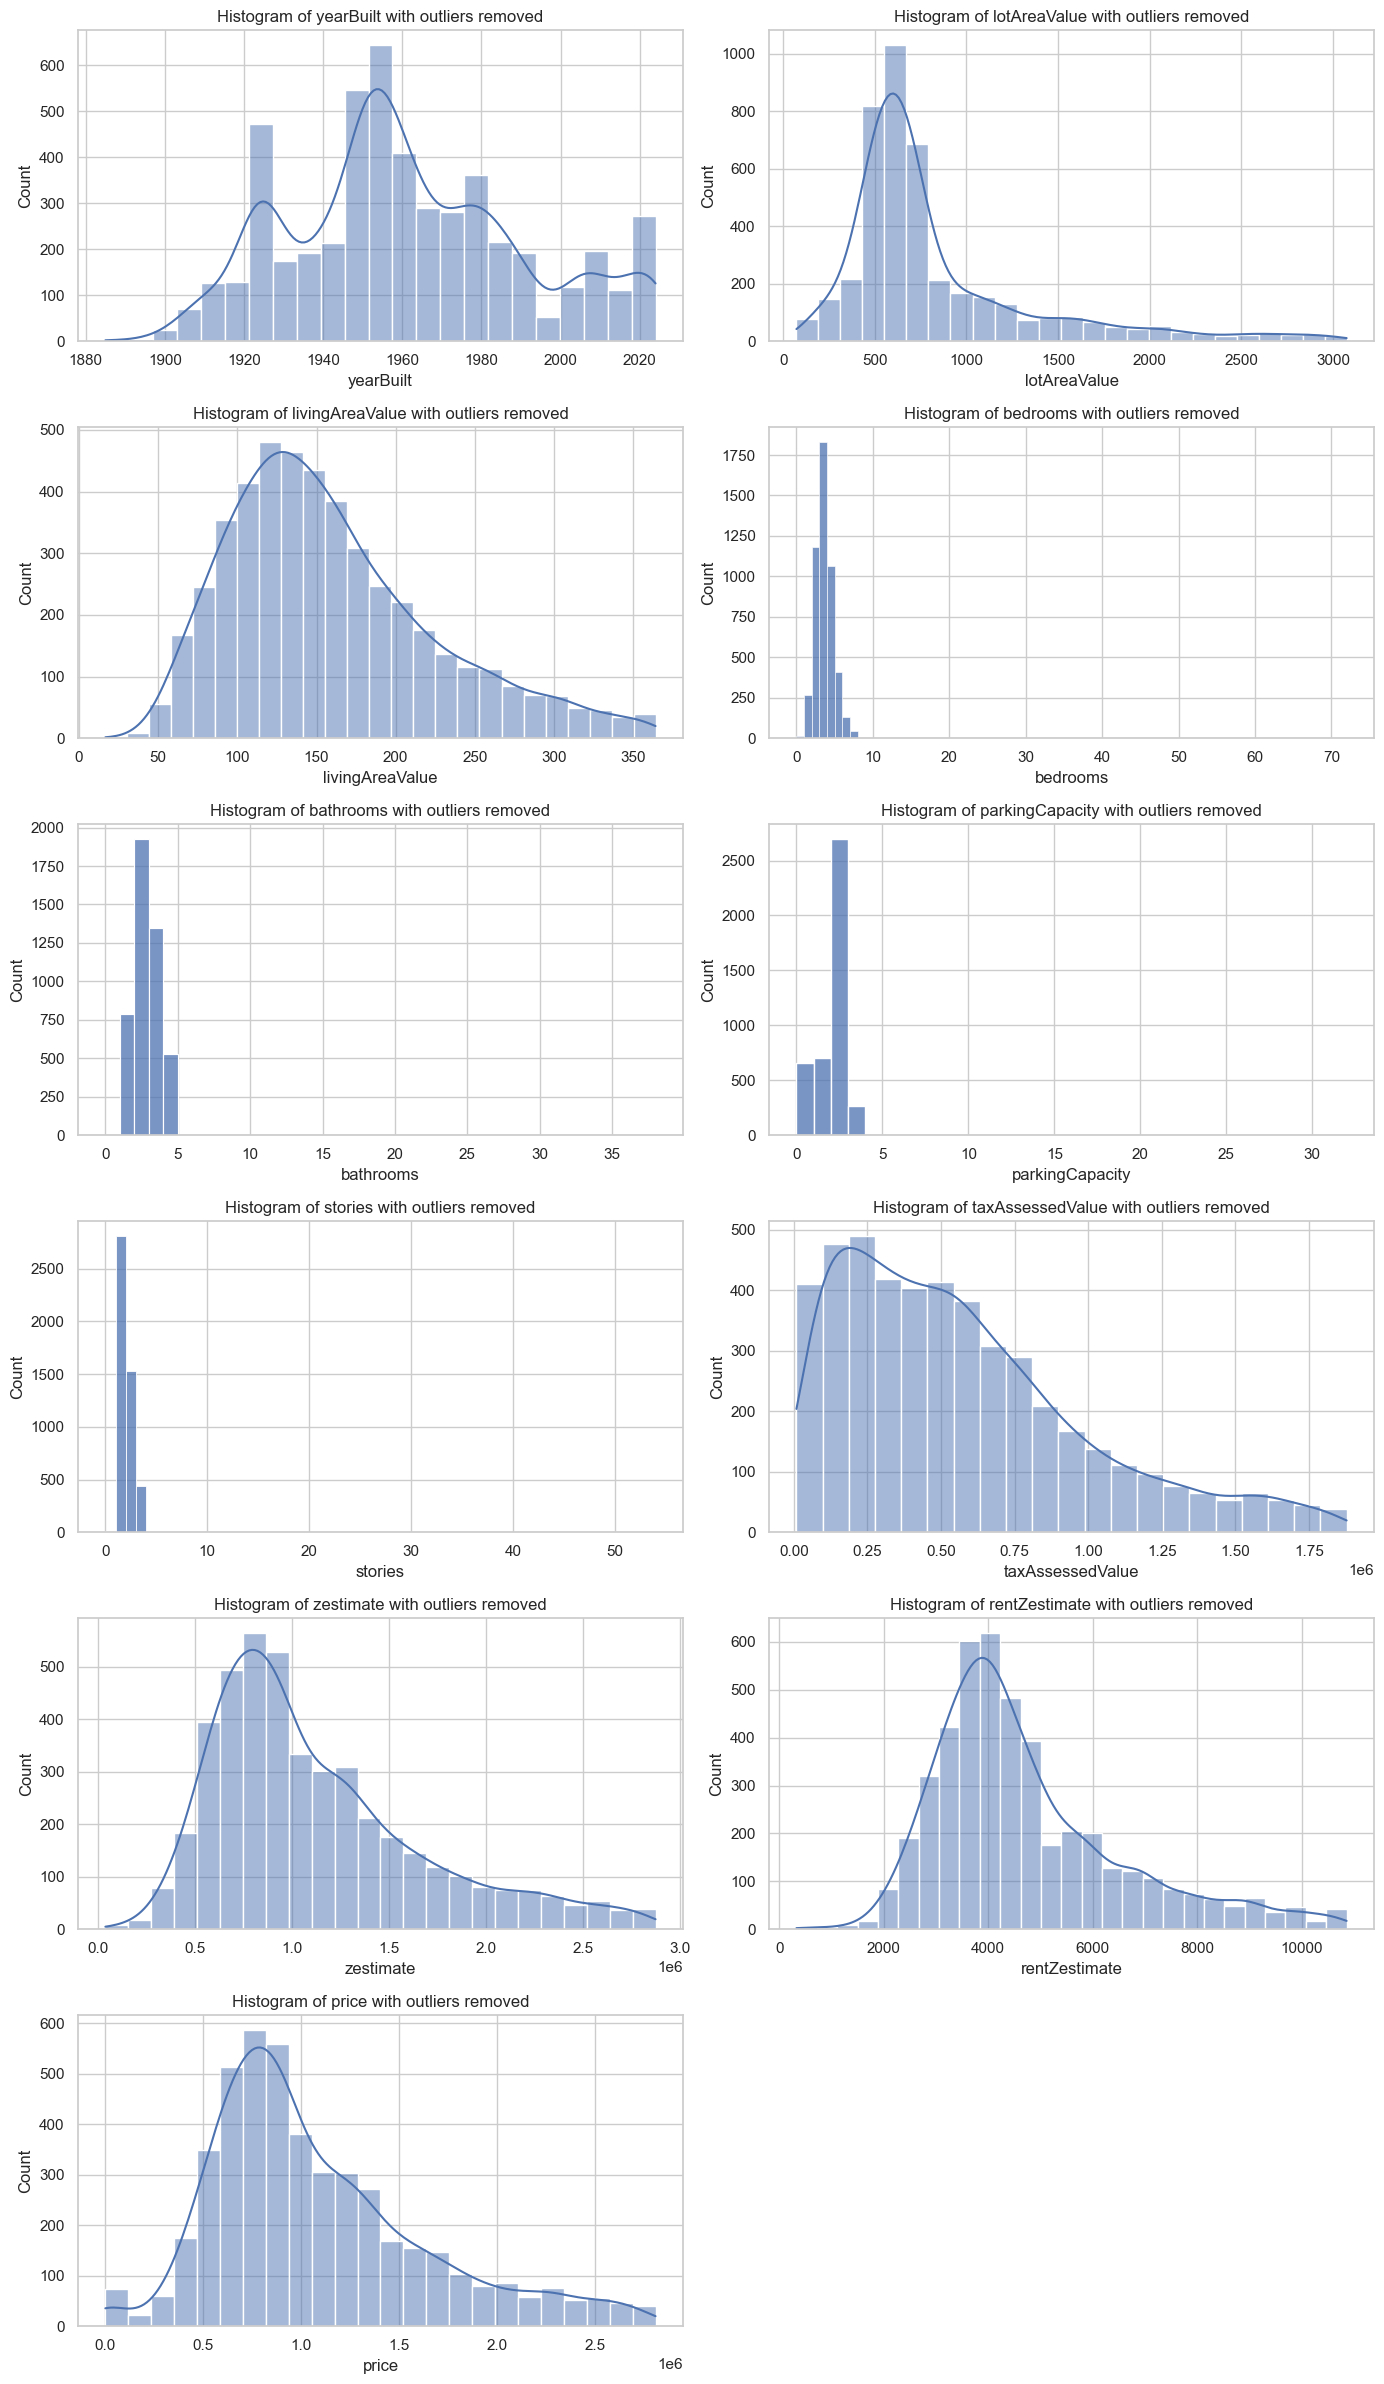

In [332]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7 * num_cols, 4 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    outliers = show_outliers(df, feature)
    df_no_outliers = df.drop(outliers.index)
    data = df_no_outliers[feature]
    if feature in ["bedrooms", "bathrooms", "stories", "parkingCapacity"]:
        bins = range(math.ceil(min(df[feature])), math.ceil(max(df[feature])) + 1)
        sns.histplot(data, bins=bins, kde=False, ax=axes[i])
    else:
        sns.histplot(data, bins=calc_num_of_bins_scott_rule(data), kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature} with outliers removed')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

### Outliers

In [333]:
import math 

def show_boxplot(df, feature):
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)
    plt.show()
    
def show_hist(df, feature, discrete = False, bins_alg = calc_num_of_bins_sturges_rule):
    if discrete:
        bins = range(math.ceil(min(df[feature])), math.ceil(max(df[feature])) + 1)
        sns.histplot(df[feature], bins=bins, kde=False)
        plt.xticks(bins)
    else:
        bins = bins_alg(df[feature])
        sns.histplot(df[feature], bins=bins, kde=True)
    
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

#### LotAreaValue

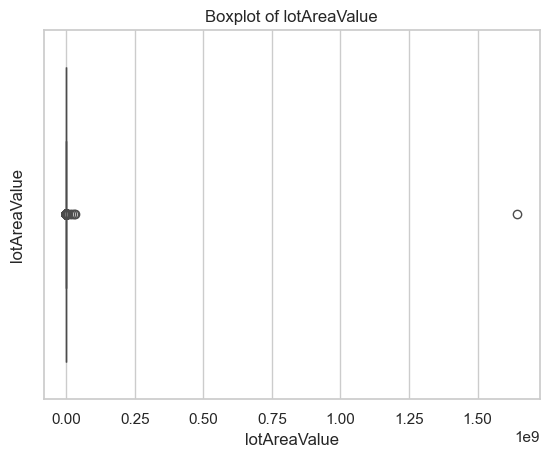

In [334]:
show_boxplot(df, 'lotAreaValue')

In [335]:
df[df['lotAreaValue'] > 1e9]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
106,91316,5460 White Oak Ave UNIT A214,CONDO,1971,1.644773e+09,91.97397,2,2.0,3.0,['Wood'],...,2498.0,"[('2008-04-24', 210000), ('2007-09-18', 319000...",270000,2,1,1,0,0,1,1


In [336]:
df = df[df['lotAreaValue'] < 1e9]

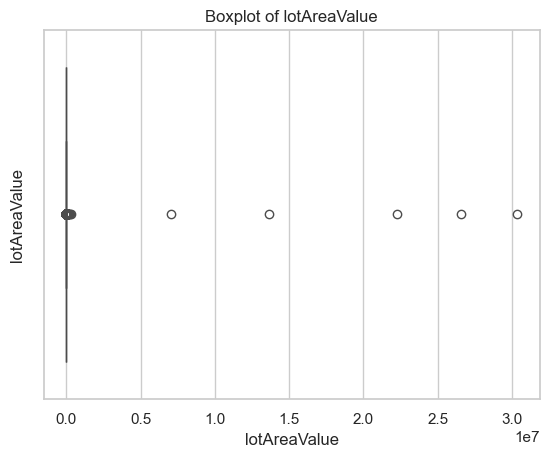

In [337]:
show_boxplot(df, 'lotAreaValue')

In [338]:
df[df['lotAreaValue'] > 1e6]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
21,91335,7317 White Oak Ave,SINGLE_FAMILY,1951,22257730.00,47.566336,2,1.0,3.0,[],...,2500.0,[],2500,0,0,0,0,0,0,0
44,91345,14377 Germain St,SINGLE_FAMILY,1955,30351450.00,164.066698,3,2.0,1.0,['Wood'],...,3999.0,"[('2022-02-15', 840000), ('2010-12-01', 339500...",4000,1,1,1,0,0,0,0
1137,90002,9614 Grape St,SINGLE_FAMILY,2024,13658152.50,123.096475,4,3.0,1.0,[],...,3640.0,"[('2022-12-02', 435000), ('2022-09-14', 359803)]",690000,2,1,1,0,0,0,1
3331,90732,2501 Bowfin Ave,SINGLE_FAMILY,1954,26600010.78,138.611276,3,2.0,1.0,[],...,4500.0,"[('2020-05-18', 805000), ('1998-08-28', 329000)]",1280000,2,1,0,1,0,0,1
3800,90024,10727 Wilshire Blvd APT 403,CONDO,2001,7061770.70,162.115735,2,3.5,2.6,[],...,5937.0,"[('2011-09-16', 960000), ('2006-07-05', 135000...",1539473,0,1,1,0,0,0,0


In [339]:
df = df[df['lotAreaValue'] < 1e6]

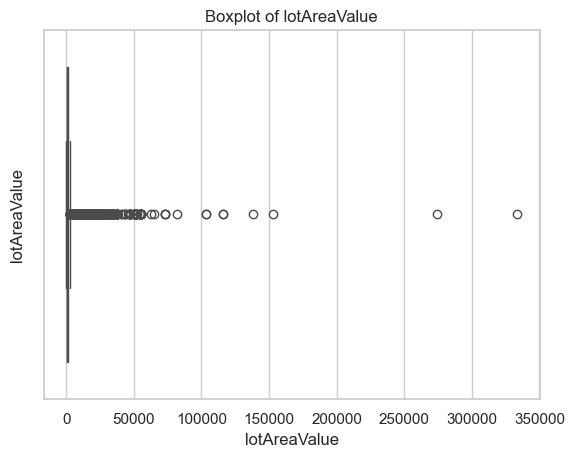

In [340]:
show_boxplot(df, 'lotAreaValue')

In [341]:
df[df["lotAreaValue"] > 1e5]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
95,91304,24425 Woolsey Canyon Rd SPACE 34,MANUFACTURED,1980,153218.571146,134.709350,2,2.0,1.0,['Laminate'],...,697.0,[],157000,2,1,1,0,0,1,0
764,90016,5187 Village Grn,CONDO,1942,273972.422000,85.099148,1,1.0,1.0,['Wood'],...,3028.0,"[('2023-11-03', 550000), ('2012-02-03', 170000)]",608500,1,0,1,0,0,0,1
1978,91342,12207 Via Santa Barbara,SINGLE_FAMILY,1999,116106.032144,173.821513,3,3.0,2.0,[],...,3716.0,"[('1999-08-19', 231000)]",860000,3,1,1,1,0,1,1
2192,91342,12101 Via Santa Barbara,SINGLE_FAMILY,1999,116106.032144,222.409782,4,4.0,2.0,[],...,4896.0,"[('2009-05-20', 425000), ('1999-11-24', 266000)]",905000,3,1,1,1,0,0,1
2205,91342,13173 La Tierra Way,SINGLE_FAMILY,2001,333546.248060,258.363243,3,3.0,2.0,[],...,4308.0,[],900000,2,1,1,0,0,0,1
3177,91307,23236 W Vail Dr,SINGLE_FAMILY,1987,138495.285094,183.018910,3,3.0,2.0,"['Carpet', 'Tile', 'Wood']",...,4270.0,"[('2017-10-17', 799000)]",1220000,3,1,1,1,1,1,1
3420,90077,10125 Hollow Glen Cir,CONDO,1970,103172.075832,198.533711,3,3.0,1.4,[],...,7500.0,[],1313000,0,1,1,0,0,0,0
4088,90077,10136 Hollow Glen Cir,SINGLE_FAMILY,1970,103171.458212,217.300117,4,3.0,2.0,"['Carpet', 'Wood', 'Wood', 'Marble', 'Stone']",...,8570.0,"[('1995-08-01', 420000)]",1786000,2,1,1,1,1,0,1


In [342]:
df = df[df["lotAreaValue"] < 1e5]

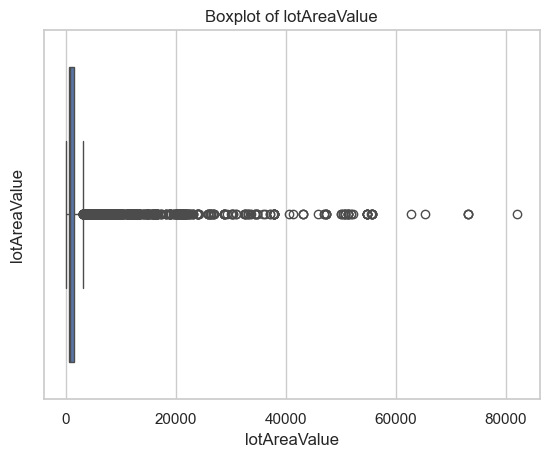

In [343]:
show_boxplot(df, 'lotAreaValue')

In [344]:
df[df["lotAreaValue"] > 60000]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
74,91304,8811 Canoga Ave SPACE 535,MANUFACTURED,1971,82058.180220,124.861632,2,2.0,1.0,[],...,330.0,[],85000,1,1,1,0,0,0,1
3630,90067,2393 Century Hl,TOWNHOUSE,1980,73170.061602,211.261422,2,3.0,3.0,"['Carpet', 'Vinyl', 'Marble', 'Tile', 'Other']",...,8870.0,[],1427000,3,1,1,1,0,0,1
3766,90067,2302 Century Hl,TOWNHOUSE,1980,73149.017930,291.158002,2,4.0,4.0,"['Carpet', 'Tile', 'Mixed', 'Parquet']",...,11791.0,"[('2023-07-06', 608397), ('2022-10-31', 60755)]",1525000,3,1,1,1,0,0,1
4187,90049,12377 Ridge Cir,SINGLE_FAMILY,1979,65212.720784,278.801903,2,3.0,2.0,"['Marble', 'Wood']",...,11442.0,"[('2013-03-22', 1230000), ('1999-08-31', 740000)]",1860000,2,1,1,1,0,0,1
4430,90067,2335 Century Hl,CONDO,1980,73149.017930,234.487172,2,4.0,1.6,['Wood'],...,8410.0,[],2250000,3,1,1,1,0,0,1
4907,91040,9540 Dale Ave,SINGLE_FAMILY,1952,62666.031786,468.416926,4,5.0,2.0,"['Laminate', 'Tile', 'Wood']",...,15641.0,"[('2019-01-31', 2650000), ('2011-12-29', 10000...",4000000,22,1,1,1,1,1,1


In [345]:
lot_area_outliers = show_outliers(df, 'lotAreaValue')
lot_area_outliers["homeType"].value_counts()

homeType
CONDO            519
TOWNHOUSE        219
SINGLE_FAMILY     68
APARTMENT          6
MANUFACTURED       2
MULTI_FAMILY       1
Name: count, dtype: int64

In [346]:
#df.loc(df["homeType"].isin(['CONDO', 'APARTMENT', "TOWNHOUSE"]), 'lotAreaValue') = df["livingAreaValue"]
#df.drop(lot_area_outliers[~lot_area_outliers['homeType'].isin(['CONDO', 'APARTMENT', "TOWNHOUSE"])].index, inplace=True)

In [347]:
df['log_lotAreaValue'] = np.log10(df['lotAreaValue'])

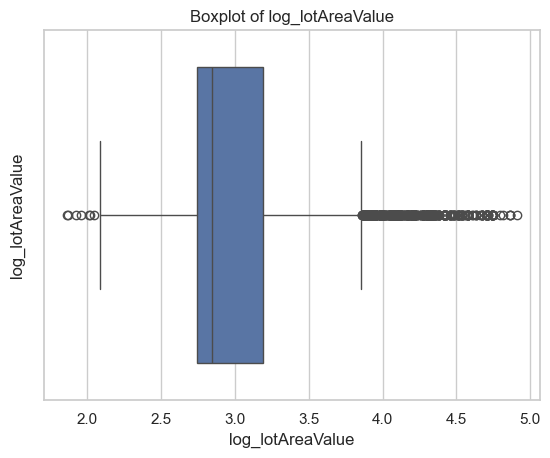

In [348]:
show_boxplot(df, 'log_lotAreaValue')

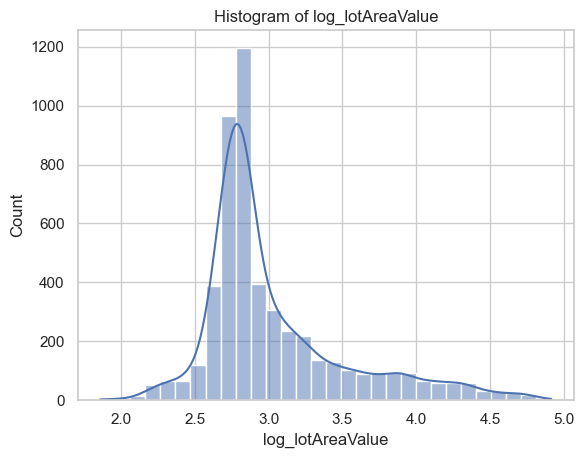

In [349]:
show_hist(df, 'log_lotAreaValue', bins_alg=calc_num_of_bins_scott_rule)

In [350]:
df["lotAreaValue"].skew()

5.2209326644764245

In [351]:
df["log_lotAreaValue"].skew()

1.4238809033026052

#### Living Area

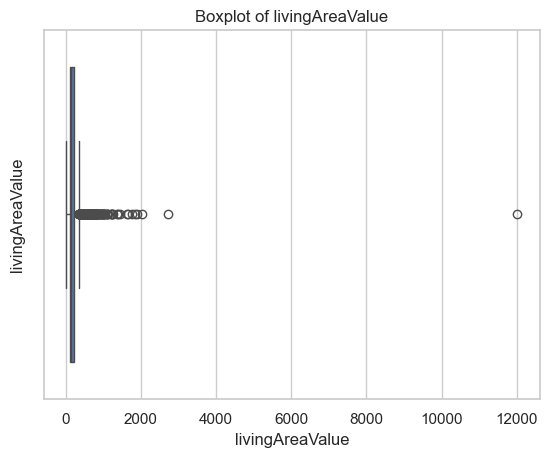

In [352]:
show_boxplot(df, 'livingAreaValue')

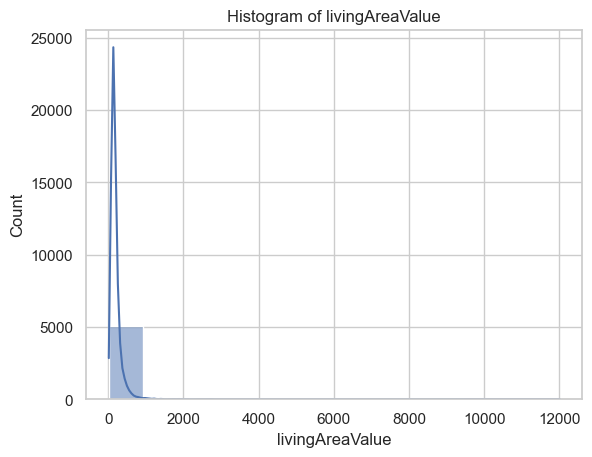

In [353]:
show_hist(df, 'livingAreaValue')

In [354]:
df[df['livingAreaValue'] > 1250]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView,log_lotAreaValue
1674,91402,9146 Willis Ave,SINGLE_FAMILY,1976,1618.744000,1618.744000,4,2.0,1.8,[],...,"[('2009-05-22', 299500), ('2008-04-16', 540000...",800000,2,1,1,0,0,0,0,3.209178
4809,91605,13135 Vanowen St,MULTI_FAMILY,1960,1547.923950,1399.769501,33,25.0,2.0,[],...,[],3264000,14,1,1,0,0,0,0,3.189750
4846,90033,456 S Breed St,MULTI_FAMILY,1972,1751.871871,1751.871871,25,25.0,3.0,[],...,[],3600000,0,0,0,0,0,0,0,3.243502
4868,90210,9625 Oak Pass Rd,SINGLE_FAMILY,1974,1855.080624,1855.080624,4,4.0,2.0,"['Wood', 'Marble', 'Mixed', 'Tile', 'Cement', ...",...,"[('2018-08-09', 9000), ('2015-12-08', 1900000)...",3607500,4,1,1,1,1,1,1,3.268363
4961,90006,1029 Elden Ave,MULTI_FAMILY,1991,2024.263467,2024.263467,36,35.0,3.0,"['Laminate', 'Carpet']",...,[],4600000,32,1,1,0,0,0,0,3.306267
4980,90003,5869-5875 S San Pedro St,MULTI_FAMILY,2023,1667.330141,1667.330141,36,28.0,3.0,['Wood'],...,[],4800000,8,1,1,0,0,0,1,3.222022
5034,90034,10915 Rose Ave,MULTI_FAMILY,1971,1899.866350,1899.866350,31,31.0,2.0,[],...,[],4975000,0,1,0,0,0,0,0,3.278723
5060,90210,2859 Coldwater Canyon Dr,SINGLE_FAMILY,1959,12009.866422,12009.866422,7,6.0,2.0,['Other'],...,"[('2022-01-31', 11200000), ('2016-01-15', 1221...",7800000,20,1,1,1,0,0,1,4.079538
5069,91436,15824 Valley Vista Blvd,SINGLE_FAMILY,2024,1442.300904,1442.300904,5,7.0,2.0,['Wood'],...,"[('2022-06-30', 2850000), ('1996-09-13', 830000)]",8000000,3,1,1,1,0,0,1,3.159056
5085,90004,4804 Oakwood Ave,APARTMENT,2022,2709.608898,2709.608898,6,4.0,2.6,[],...,[],13450000,0,1,0,0,0,0,0,3.432907


In [355]:
df = df[df["livingAreaValue"] < 1250]

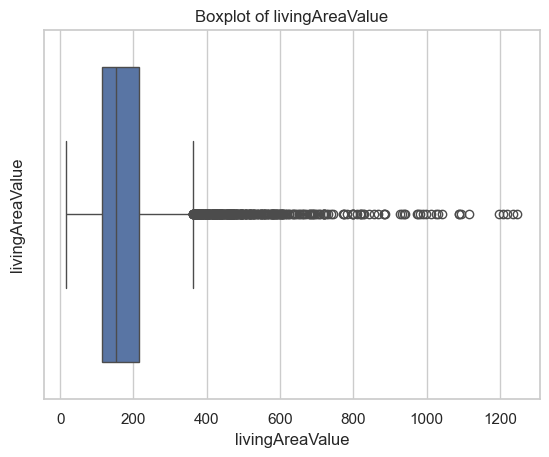

In [356]:
show_boxplot(df, 'livingAreaValue')

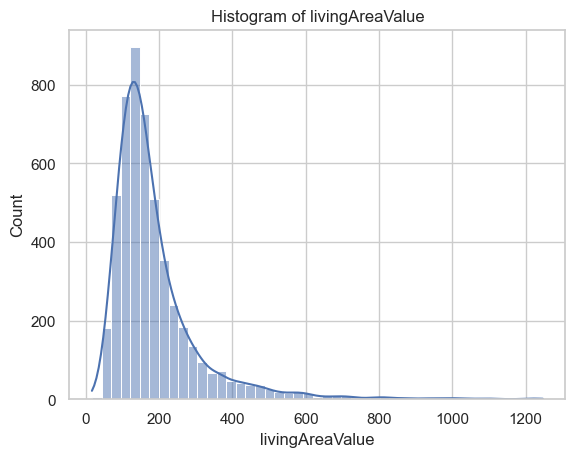

In [357]:
show_hist(df, 'livingAreaValue', bins_alg=calc_num_of_bins_scott_rule)

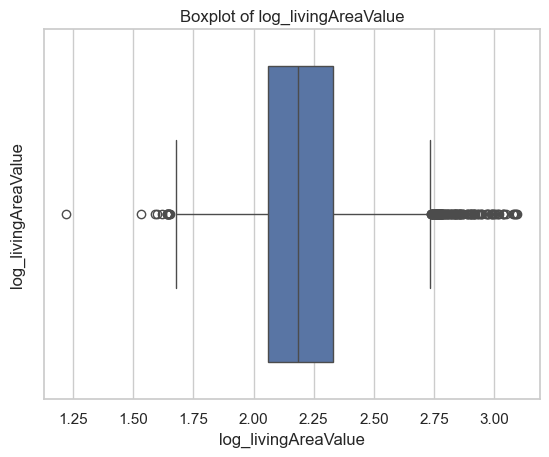

In [358]:
df["log_livingAreaValue"] = np.log10(df["livingAreaValue"])

show_boxplot(df, 'log_livingAreaValue')

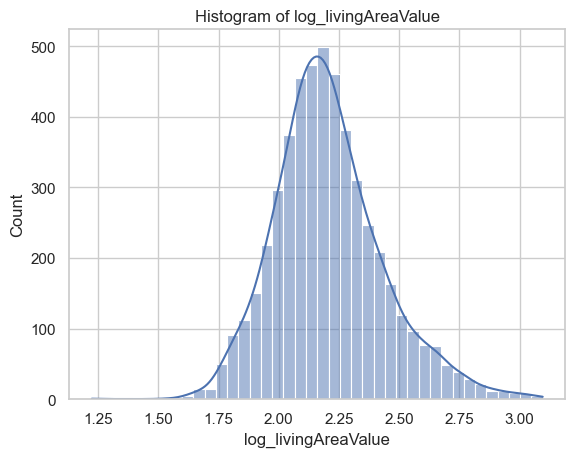

In [361]:
show_hist(df, 'log_livingAreaValue', bins_alg=calc_num_of_bins_scott_rule)

In [362]:
df["log_livingAreaValue"].skew()

0.5788024874027203

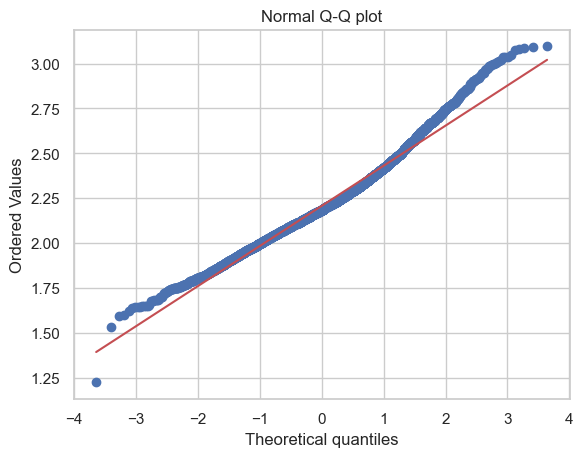

In [363]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df['log_livingAreaValue'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

#### bedrooms

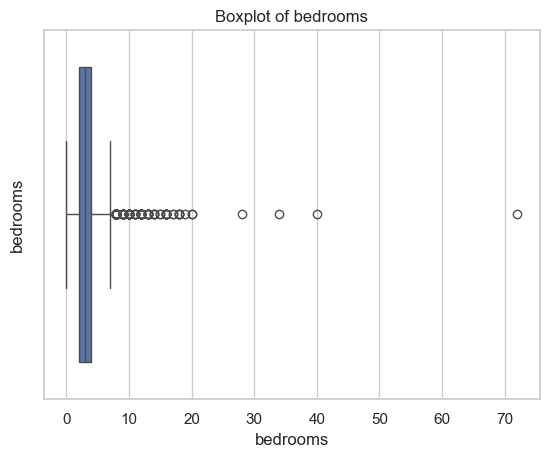

In [364]:
show_boxplot(df, 'bedrooms')

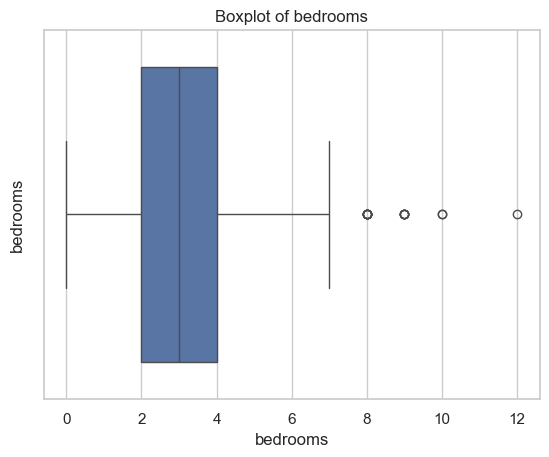

In [365]:
show_boxplot(df[df["homeType"] != "MULTI_FAMILY"], 'bedrooms')

In [366]:
df[df["homeType"] != "MULTI_FAMILY"]["bedrooms"].value_counts()

bedrooms
3     1793
2     1151
4      960
5      352
1      261
6       85
7       19
0       16
8        8
9        5
10       2
12       1
Name: count, dtype: int64

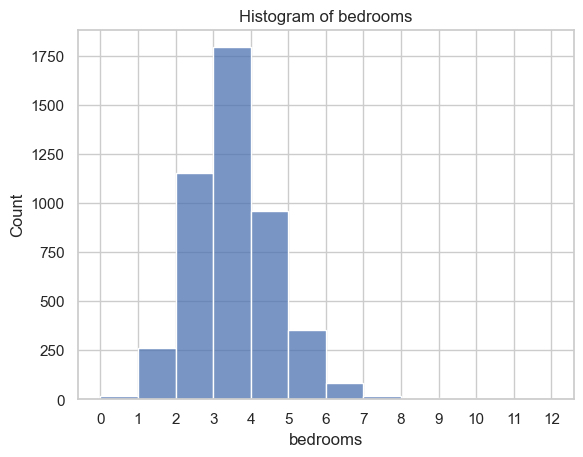

In [367]:
show_hist(df[df["homeType"] != "MULTI_FAMILY"], 'bedrooms', discrete=True)

#### bathrooms

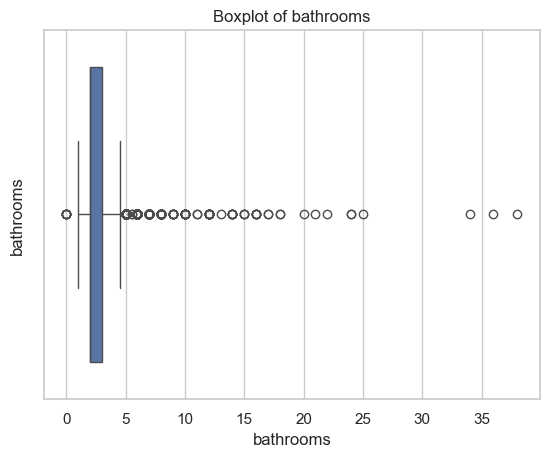

In [368]:
show_boxplot(df, 'bathrooms')

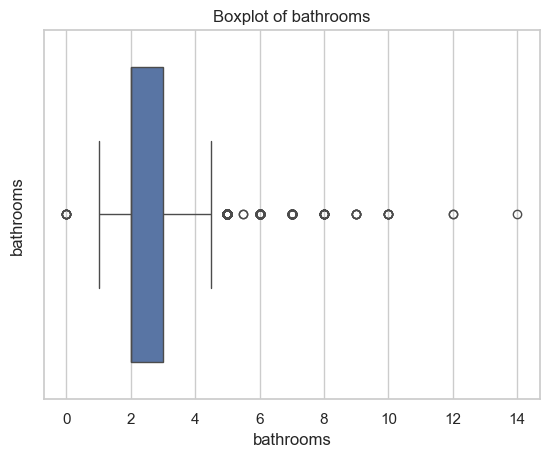

In [369]:
show_boxplot(df[df["homeType"] != "MULTI_FAMILY"], 'bathrooms')

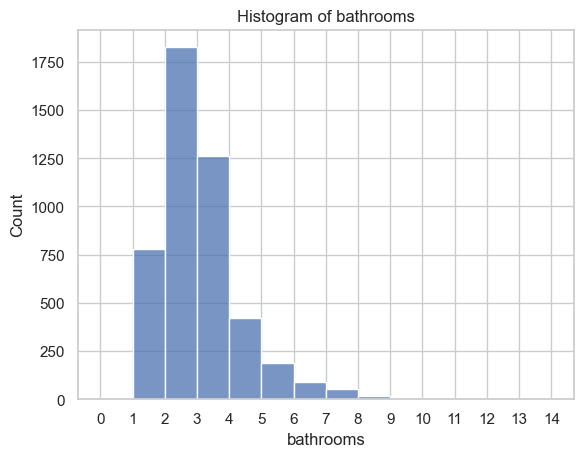

In [370]:
show_hist(df[df["homeType"] != "MULTI_FAMILY"], 'bathrooms', discrete=True)

### Parking Capacity

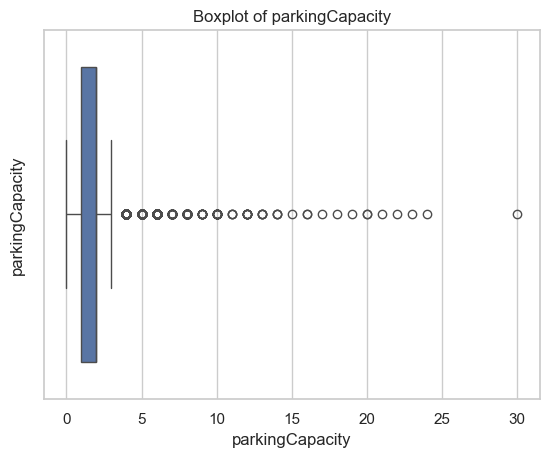

In [371]:
show_boxplot(df, 'parkingCapacity')

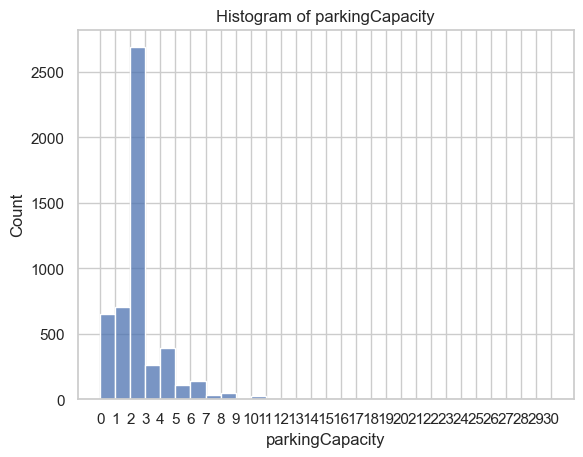

In [372]:
show_hist(df, 'parkingCapacity', discrete=True)

In [373]:
df[df["parkingCapacity"] > 15]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView,log_lotAreaValue,log_livingAreaValue
431,90004,532 N Rossmore Ave APT 409,CONDO,1972,1737.721684,65.125003,1,1.0,4.0,"['Carpet', 'Tile']",...,499500,21,1,1,0,0,0,1,3.239980,1.813748
1729,91331,13960 Filmore St,SINGLE_FAMILY,1929,1016.824672,98.105568,3,2.0,1.0,[],...,810000,30,1,0,1,0,0,1,3.007246,1.991694
4374,90065,3429 Andrita St,MULTI_FAMILY,1962,1257.764088,800.266442,14,17.0,3.0,[],...,2175000,23,1,1,0,0,0,0,3.099599,2.903235
4648,90731,970-964 W Santa Cruz St,MULTI_FAMILY,1979,1207.554781,718.697608,16,10.0,2.0,[],...,2760000,18,0,1,0,0,0,0,3.081907,2.856546
4659,91606,11848 Oxnard St,MULTI_FAMILY,1954,1757.146612,941.293196,16,14.0,3.0,"['Mixed', 'Laminate', 'Wood', 'Tile', 'Linoleu...",...,2750000,17,1,1,1,0,0,0,3.244808,2.973725
4676,90026,275 Lucas Ave,MULTI_FAMILY,1964,1129.237449,999.450474,8,22.0,2.0,[],...,2908000,24,0,0,0,0,0,0,3.052785,2.999761
4710,91325,17302 Lassen St,SINGLE_FAMILY,1916,5880.492266,1024.627187,12,10.0,1.0,"['Vinyl', 'Wood']",...,3000000,20,1,1,1,1,0,1,3.769414,3.010566
4907,91040,9540 Dale Ave,SINGLE_FAMILY,1952,62666.031786,468.416926,4,5.0,2.0,"['Laminate', 'Tile', 'Wood']",...,4000000,22,1,1,1,1,1,1,4.797032,2.670633
4946,91601,10916 Peach Grove St,MULTI_FAMILY,1986,926.242910,926.242910,20,20.0,3.0,[],...,4057725,19,1,1,0,0,0,0,2.966725,2.966725
5001,90025,1218 McClellan Dr,MULTI_FAMILY,1972,1092.353474,1092.353474,16,16.0,2.0,[],...,4965000,16,0,0,0,0,0,0,3.038363,3.038363


#### stories

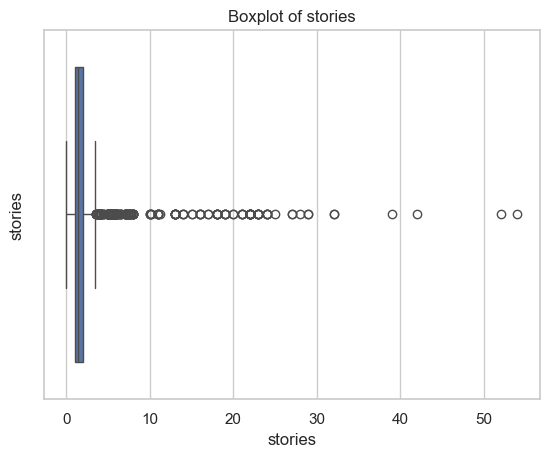

In [374]:
show_boxplot(df, 'stories')

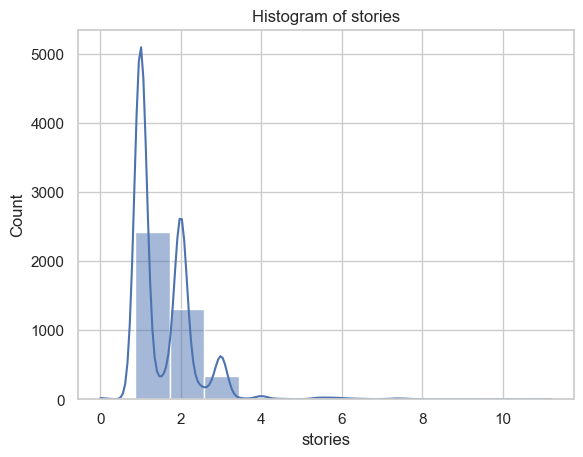

In [375]:
show_hist(df[df['homeType'] != 'CONDO'],'stories', discrete=False)

In [376]:
df.to_csv('data_with_price_outliers.csv', index=False)

#### price


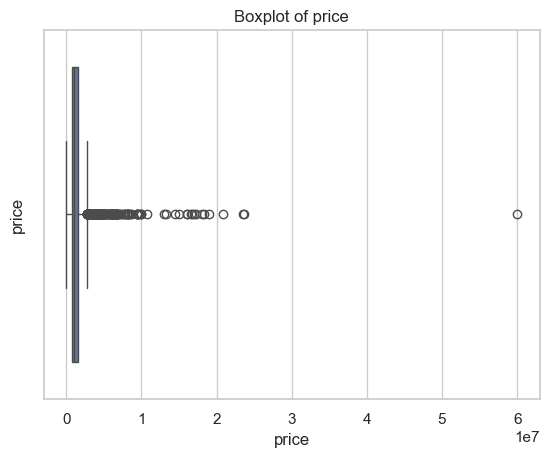

In [377]:
show_boxplot(df, 'price')

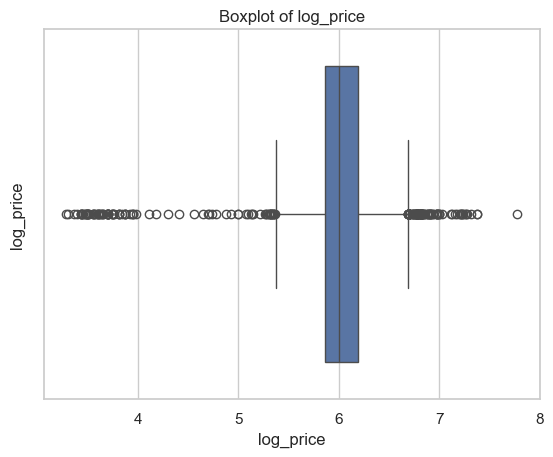

In [378]:
df["log_price"] = np.log10(df['price'])
show_boxplot(df, 'log_price')

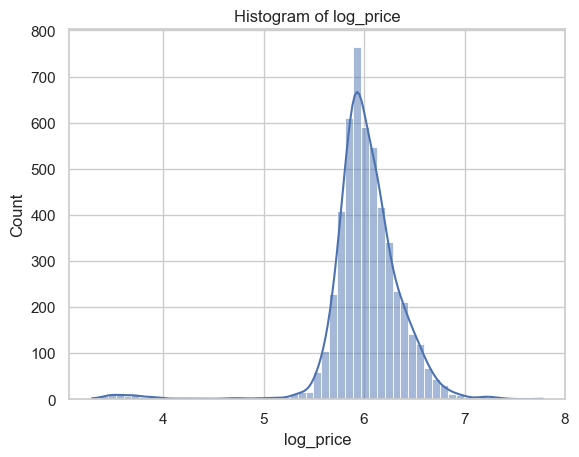

In [379]:
show_hist(df, 'log_price', bins_alg=calc_num_of_bins_scott_rule)

In [380]:
show_outliers(df, 'log_price')[["zestimate", "price"]]

,zestimate,price
0,701200.0,3050
1,734100.0,3100
2,464800.0,2800
3,759600.0,3600
4,498300.0,3100
...,...,...
5098,NaN,16000000
5099,13650900.0,13250000
5100,17094300.0,16750000
5101,13303200.0,12999000


In [381]:
df["zestimate/price"] = df["zestimate"] / df["price"]

In [382]:
df["zestimate/price"].describe()

count    4827.000000
mean        3.883203
std        26.268627
min         0.321809
25%         1.006095
50%         1.016375
75%         1.026667
max       409.863014
Name: zestimate/price, dtype: float64

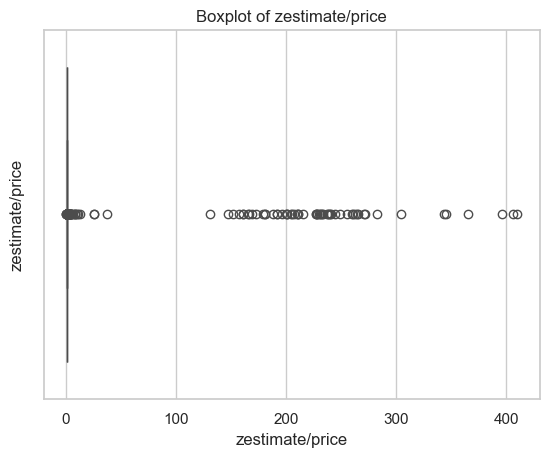

In [383]:
show_boxplot(df, 'zestimate/price')

In [384]:
df = df[df["zestimate/price"] < 10]

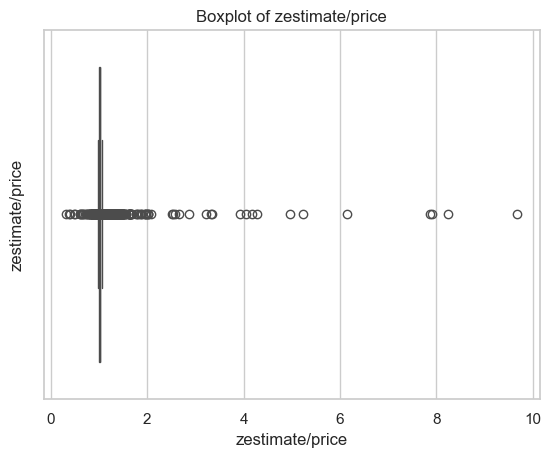

In [385]:
show_boxplot(df, 'zestimate/price')

In [386]:
df = df[df["zestimate/price"] < 2]

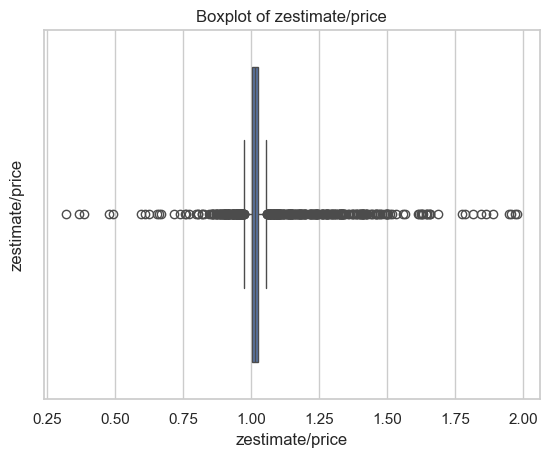

In [387]:
show_boxplot(df, 'zestimate/price')

In [388]:
df = df[df["zestimate/price"] > 0.5]

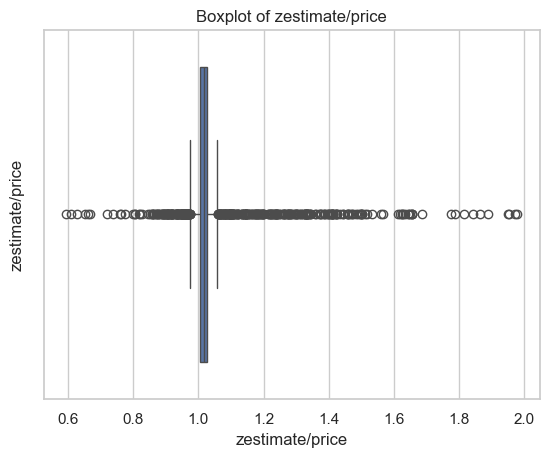

In [389]:
show_boxplot(df, 'zestimate/price')

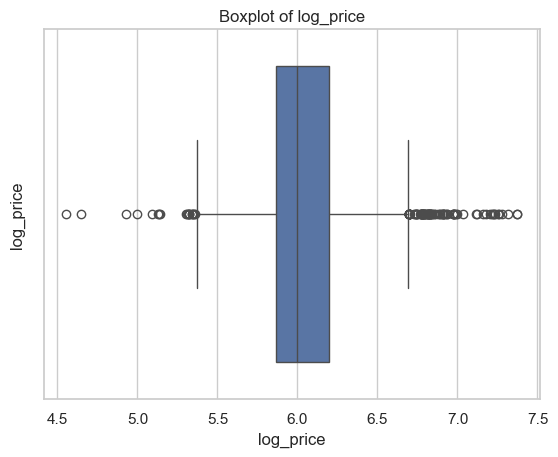

In [390]:
show_boxplot(df, "log_price")

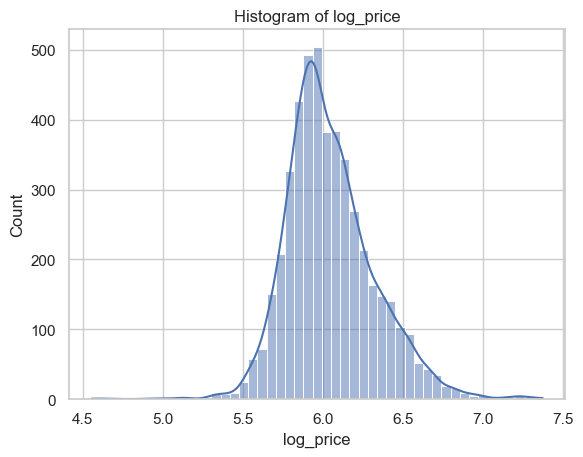

In [391]:
show_hist(df, "log_price", bins_alg=calc_num_of_bins_scott_rule)

In [392]:
skewness = df["log_price"].skew()
print(f"Skewness: {skewness:.2f}")

Skewness: 0.64


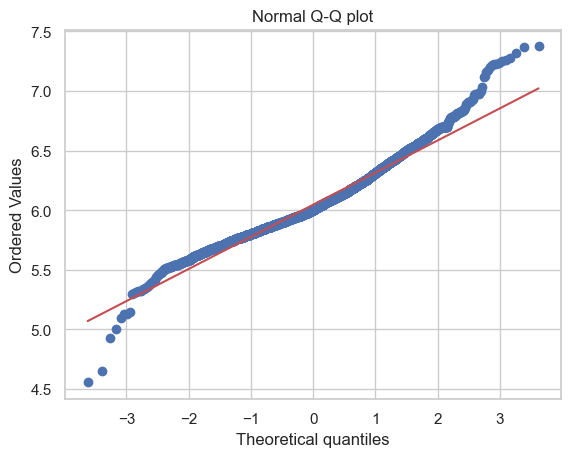

In [393]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df['log_price'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [394]:
df["homeType"].value_counts()

homeType
SINGLE_FAMILY    3133
CONDO             890
MULTI_FAMILY      396
TOWNHOUSE         293
APARTMENT          11
MANUFACTURED       10
LOT                 2
Name: count, dtype: int64

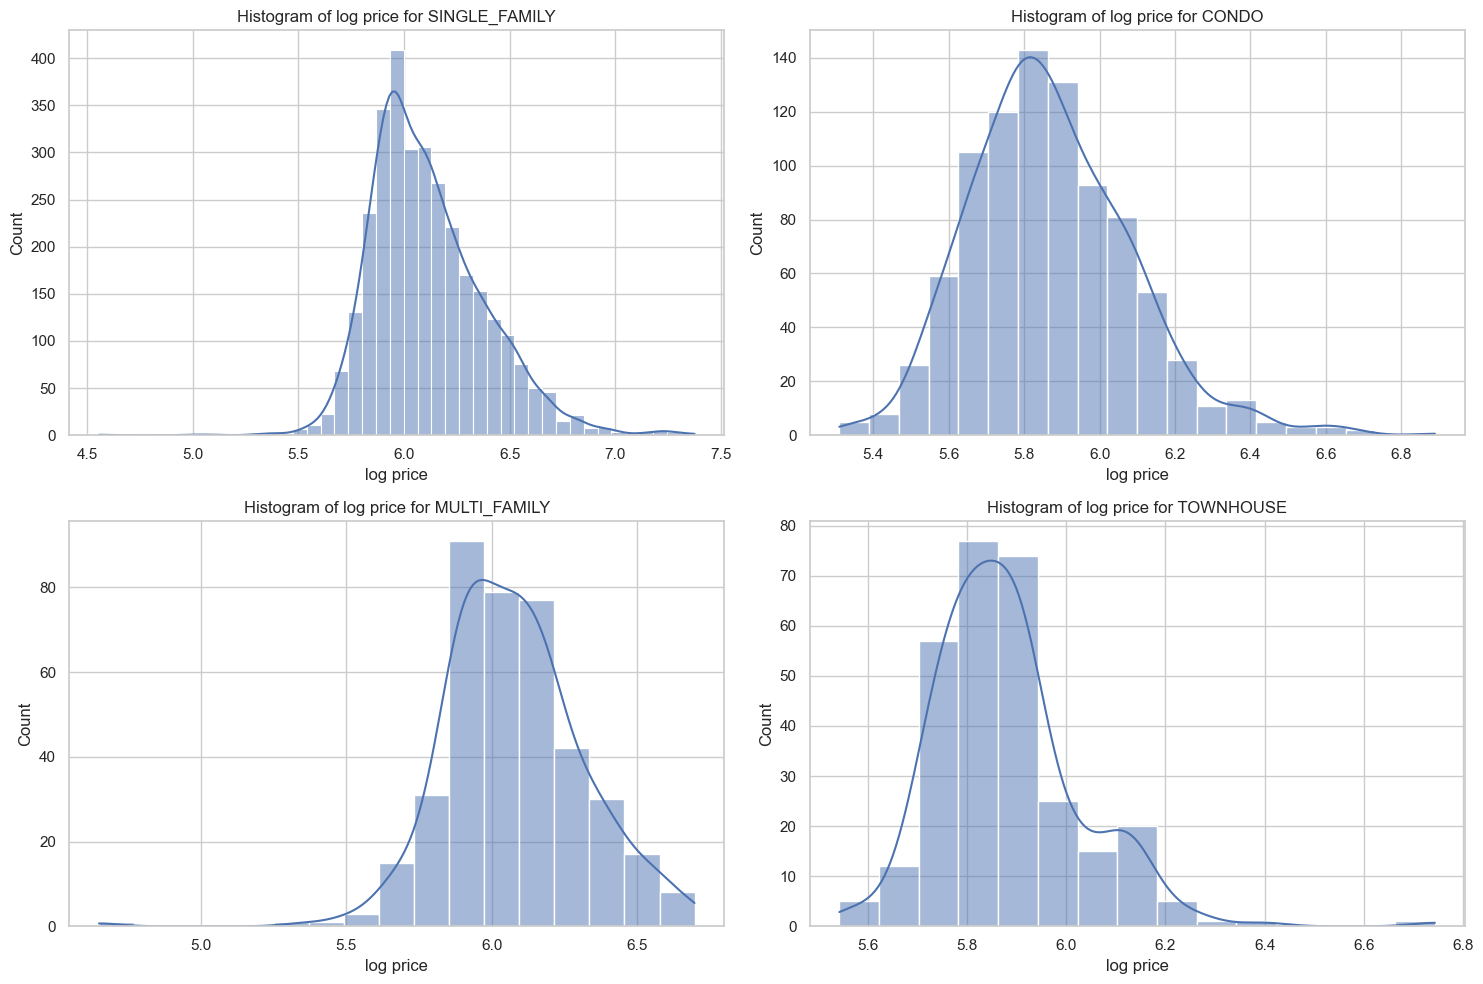

In [395]:
types = ["SINGLE_FAMILY", "CONDO", "MULTI_FAMILY", "TOWNHOUSE"]

#plot log_price for each home type
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
for i, home_type in enumerate(types):
    data = df[df["homeType"] == home_type]["log_price"]
    sns.histplot(data, bins=calc_num_of_bins_scott_rule(data), kde=True, ax=ax[i])
    ax[i].set_title(f'Histogram of log price for {home_type}')
    ax[i].set_xlabel('log price')
    ax[i].set_ylabel('Count')

plt.tight_layout()

#### tax assessed value

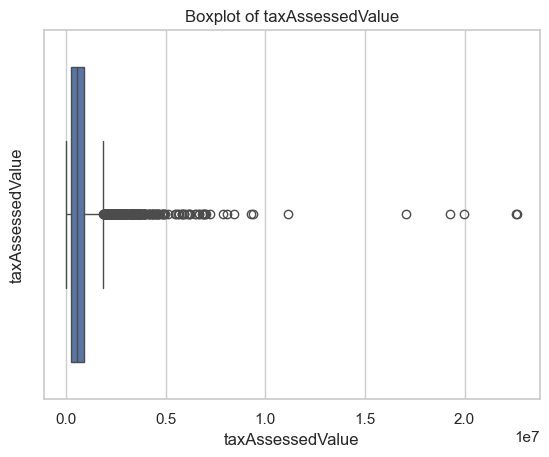

In [396]:
show_boxplot(df, 'taxAssessedValue')

In [397]:
df["log_taxAssessedValue"] = np.log10(df['taxAssessedValue'])

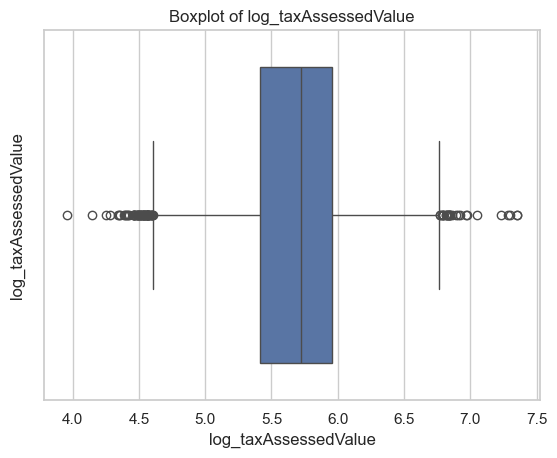

In [398]:
show_boxplot(df, 'log_taxAssessedValue')

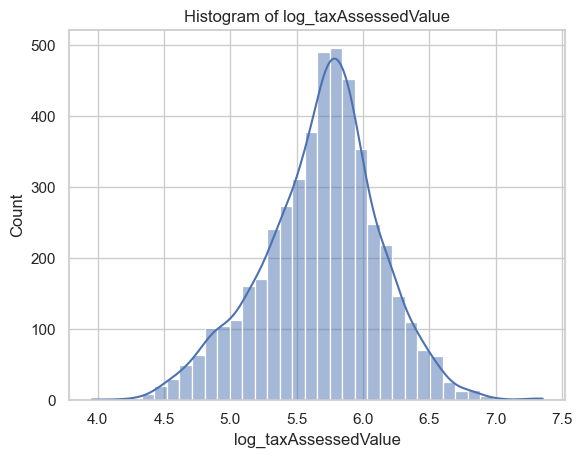

In [399]:
show_hist(df, 'log_taxAssessedValue', bins_alg=calc_num_of_bins_scott_rule)

In [400]:
df.drop(columns=["zestimate/price"], inplace=True)
df.to_csv('data_without_price_outliers.csv', index=False)